# EMAIL CLASSIFICATION

## Objectifs de ce notebook

- Explorer la construction d'un r√©seau de neurones (Multi Layer Perceptron) ainsi que ses diff√©rents types d'architectures
- Appliquer un r√©seau de nerones pour la classification d'emails (spam ou non spam).

In [1]:
# IMPORTS

# Manipulation et analyse de donn√©es sous forme de DataFrame
import pandas as pd

# Calculs num√©riques et manipulation de tableaux multidimensionnels
import numpy as np

# Visualisation de donn√©es
import matplotlib.pyplot as plt

# Division des donn√©es en ensemble d'entra√Ænement et de test
from sklearn.model_selection import train_test_split

# Evaluation du mod√®le
from sklearn.metrics import classification_report, confusion_matrix

# Transformation de textes en matrices TF-IDF (d√©tails plus bas)
from sklearn.feature_extraction.text import TfidfVectorizer

# Transformation des √©tiquettes en nombres pour la classification
from sklearn.preprocessing import LabelEncoder

# Cr√©ation et entra√Ænement de mod√®les de deep learning avec TensorFlow
import tensorflow as tf

# Redimensionner des images
from IPython.display import Image

In [ ]:
# Retirer les quotes pour charger le dataset
# T√©l√©charger en local

"""import kagglehub

path = kagglehub.dataset_download("meruvulikith/190k-spam-ham-email-dataset-for-classification")

print("Path to dataset files:", path)"""

'import kagglehub\n\npath = kagglehub.dataset_download("meruvulikith/190k-spam-ham-email-dataset-for-classification")\n\nprint("Path to dataset files:", path)'

## Etape 1 : Pr√©paration du dataset

### Chargement et premier aper√ßu du dataset

In [2]:
df = pd.read_csv("spam_Emails_data.csv")
print(df.head())
print()
print(df.describe())
print()
print(df.info())


  label                                               text
0  Spam  viiiiiiagraaaa\nonly for the ones that want to...
1   Ham  got ice thought look az original message ice o...
2  Spam  yo ur wom an ne eds an escapenumber in ch ma n...
3  Spam  start increasing your odds of success & live s...
4   Ham  author jra date escapenumber escapenumber esca...

         label    text
count   193852  193850
unique       2  193848
top        Ham      hi
freq    102160       2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193852 entries, 0 to 193851
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   193852 non-null  object
 1   text    193850 non-null  object
dtypes: object(2)
memory usage: 3.0+ MB
None


Observations : 

- 193 852 lignes
- 2 colonnes : 'label' et 'text'
- 2 valeurs distinctes de 'label' ('Spam' et 'Ham') -> **√† pr√©dire**
- 2 entr√©es de 'text' manquantes

### Il manque le contenu de 2 emails, cela les rend inutiles pour notre dataset => **on les supprime** 

In [3]:
df.dropna(inplace=True)

# Voir pour chaque colonne le nombre d'√©l√©ments vides
print(df.isnull().sum())

label    0
text     0
dtype: int64


### Explication : Vectorisation TF-IDF (term frequency - inverse document frequency)

Cette technique permet de transformer des emails (c√†d du texte) en une repr√©sentation num√©rique, exploitable pour notre MLP.

On cr√©e un vectoriseur qui va convertir du texte en une matrice de nombres, en fonction de l'importance des mots.

    => Plus un mot est important, plus son score sera √©lev√©.

Pour chaque mot w dans un document d, le TF-IDF est calcul√© ainsi : 

- TF(w) = (Nombre de fois o√π w appara√Æt dans d) / (Nombre total de mots dans d)

- IDF(w) = log (Nombre total de documents / Nombre de documents qui contiennent w)

`TF-IDF(w) = TF(w) * IDF(w)`

En d'autres termes, pour qu'un mot soit consid√©r√© comme important : 

- Il doit appara√Ætre suffisamment souvent dans un document. (TF √©lev√©)

- Il doit √™tre pr√©sent dans un peu moins de documents que les autres. (IDF √©lev√©)

Ainsi les mots tr√®s courants (ex. "le", "et", "de") ont un score faible car ils apparaissent dans presque tous les documents.

In [4]:
# Tokenisation et vectorisation
vectorizer = TfidfVectorizer(max_features=5000)  # Convertir texte en features
X = vectorizer.fit_transform(df['text']).toarray()

### Encodage des labels

Plus simple que le TF-IDF, on associe chaque label √† un nombre

In [5]:
encoder = LabelEncoder()
y = encoder.fit_transform(df['label'])  # spam = 1, ham = 0

### Division du dataset

Pour entra√Æner notre mod√®le, nous divisons le dataset en 2 ensembles.
- Ensemble d'entra√Ænement
- Ensemble de test

**Quel int√©r√™t ?** 

Cette s√©paration nous permet de tester le mod√®le sur des donn√©es qu'il n'a pas vu lors de l'entra√Ænement.

On v√©rifie sa capacit√© de g√©n√©ralisation et on √©vite le surapprentissage (overfitting).

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Etape 2 : Construction et entrainement du r√©seau de neurones

### Explication : structure du MLP (Multi Layer Perceptron)

Le mod√®le suit une architecture s√©quentielle, o√π les couches sont empil√©es les unes apr√®s les autres : 
- **1√®re couche *dense*** (128 neurones). `input_shape=(X_train.shape[1],)` => la couche attend en entr√©e un vecteur de taille √©gale au nombres de features dans le dataset d'entrainement.
    
    `activation ReLU (Rectified Linear Unit) : ReLU(x) = max(0, x)`

    Pourquoi ? aide √† √©viter la disparition de gradient (cf descente de gradient) et acc√©l√®re l'entrainement.

- **2√®me couche *dropout*** : 30% des neurones sont d√©sactiv√©s al√©atoirement √† chaque it√©ration d'entrainement.

    Pourquoi ? √©vite l'overfitting (quand le mod√®le apprend trop facilement √† l'entrainement des donn√©es) et am√©liore la g√©n√©ralisation des pr√©dictions.

- **3√®me couche *dense*** (64 neurones).

    Pourquoi une autre couche cach√©e ? apprendre des relations plus profondes entre les mots. capturer des motifs plus abstrait.

- **4√®me couche *dense*** (1 neurone). Donne la probabilit√© que le mail soit un spam.

    `activation sigmoid : sigmoid(x) = 1 / (1 + exp(-x))`

    Pourquoi sigmo√Øde ? donne en sortie une probabilit√© entre 0 et 1 : si sortie > 0.5 => spam, sinon non spam

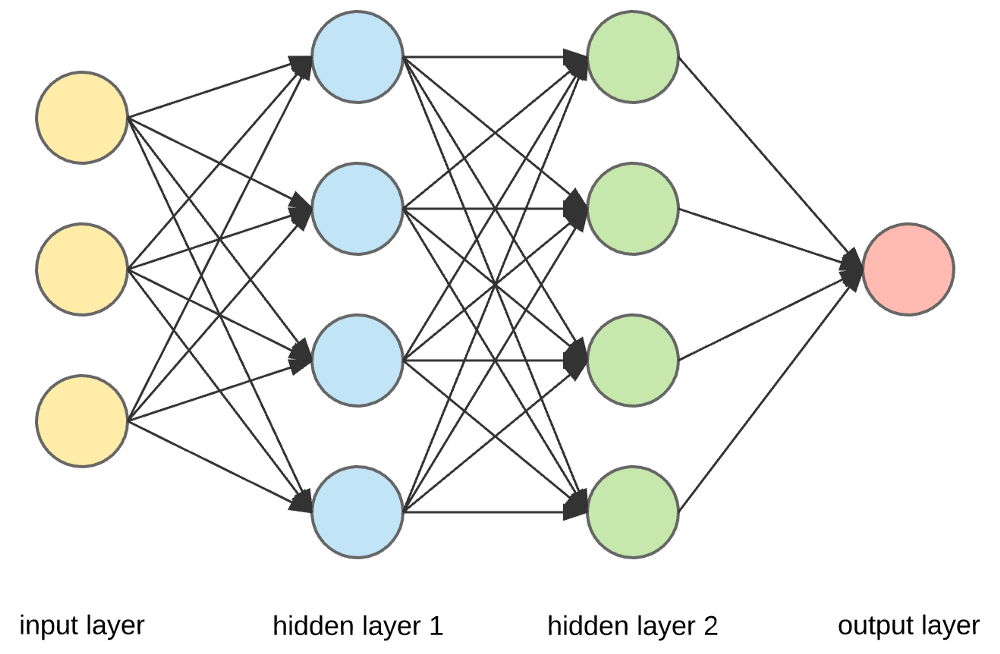

In [13]:
Image("./images/neural_network.png", width=800)

In [7]:
# Cr√©ation du mod√®le MLP
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Configuration du mod√®le
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entra√Ænement du mod√®le
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)


c:\Users\abdal\anaconda3\envs\titanic_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
4847/4847 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 27s 5ms/step - accuracy: 0.9595 - loss: 0.1200 - val_accuracy: 0.9802 - val_loss: 0.0565
Epoch 2/10
4847/4847 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 22s 4ms/step - accuracy: 0.9877 - loss: 0.0373 - val_accuracy: 0.9840 - val_loss: 0.0519
Epoch 3/10
4847/4847 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 23s 5ms/step - accuracy: 0.9940 - loss: 0.0200 - val_accuracy: 0.9868 - val_loss: 0.0515
Epoch 4/10
4847/4847 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 22s 5ms/step - accuracy: 0.9963 - loss: 0.0127 - val_accuracy: 0.9877 - val_loss: 0.0507
Epoch 5/10
4847/4847 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 20s 4ms/step - accuracy: 0.9971 - loss: 0.0092 - val_accuracy: 0.9882 - val_loss: 0.0594
Epoch 6/10
4847/4847 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 21s 4ms/step - accuracy: 0.9976 - loss: 0.0076 - val_accuracy: 

### Comprendre les m√©triques de l'apprentissage

- `Epoch` : √©poque d'apprentissage, c√†d un passage complet sur le dataset d'entrainement
- `x ms/step` : temps moyen pour traiter un batch, c√†d un morceau de dataset
- `accuracy` : pr√©cision obtenue sur les donn√©es d'entrainement
- `loss` : perte obtenue sur les donn√©es d'entrainement
- `val_accuracy` : pr√©cision obtenue sur les donn√©es de validation
- `val_loss` : perte obtenue sur les donn√©es de validation

**Note** : l'ensemble de validation est une partie du dataset d'entrainement, utilis√© pour √©valuer la performance du mod√®le **pendant l'apprentissage.**

Il aide √† d√©tecter le surapprentissage. Si `val_accuracy` est beaucoup plus faible que `accuracy` (ou si `val_loss` est beaucoup plus √©lev√© que `loss`), c'est que le mod√®le m√©morise trop et ne g√©n√©ralise pas assez.

**Attention** : L‚Äôensemble de validation est diff√©rent de l‚Äôensemble de test, qui est utilis√© uniquement **apr√®s l‚Äôentra√Ænement** final pour √©valuer la vraie performance du mod√®le.

### Explication : descente de gradient

La descente de gradient est un algorithme d‚Äôoptimisation utilis√© pour **ajuster les param√®tres** d‚Äôun mod√®le de machine learning (comme les poids d‚Äôun r√©seau de neurones) afin de r√©duire l‚Äôerreur entre ses pr√©dictions et les valeurs r√©elles.

De mani√®re g√©n√©rale, une descente de gradient sert √† trouver le **minimum d'une fonction**

Il s'agit de minimiser une fonction de co√ªt `J(Xn)`, fonction qui mesure l'erreur entre les pr√©dictions et les vraies valeurs.

* `Xn` √©tant un poids du r√©seau de neurones

La descente de gradient fonctionne comme une marche dans une vall√©e :
- Imaginons que la fonction de co√ªt est une montagne et que nous voulons descendre jusqu‚Äôau point le plus bas (le minimum global).
- √Ä chaque √©tape, nous regardons la pente et descendons dans la direction la plus abrupte pour atteindre le fond le plus rapidement possible.
- Cette pente est donn√©e par le gradient (la d√©riv√©e de la fonction de co√ªt).

It√©ration d'une descente de gradient : `Xn+1 = Xn - Œ± * f'(Xn)`

avec : 
- `Xn` le point initial
- `Xn+1` le point suivant dans l'algo de descente
- `Œ±` le taux d'apprentisage (learning rate) 
- `f'(Xn)` la d√©riv√©e (c√†d la pente) de la fonction de co√ªt au point Xn

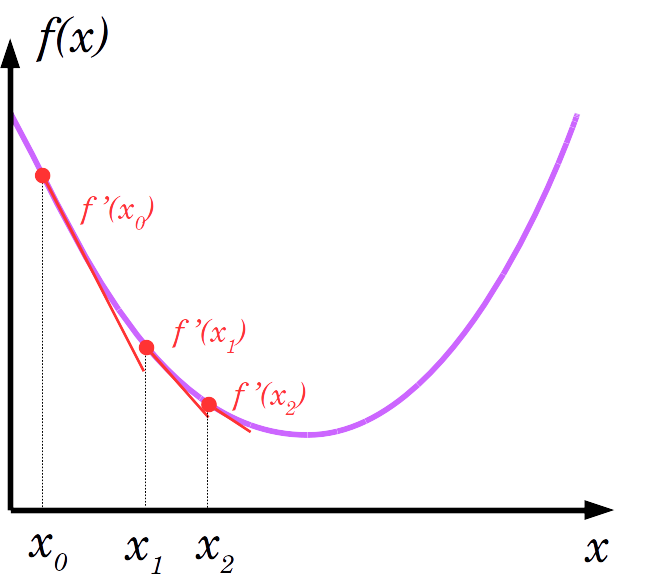

In [14]:
Image("./images/gradient-descent.png", width=800)

Le taux d'apprentisage `Œ±`, c'est la taille des *pas* effectu√©s pour atteindre le minimum de la fonction de co√ªt (le fond de la vall√©e).

Le choix de `Œ±` d√©pend du comportement de la fonction de co√ªt :
- Si `ùõº` est trop grand, on risque d‚Äôosciller et de ne jamais atteindre le minimum.
- Si `ùõº` est trop petit, l‚Äôapprentissage sera (trop) lent.

Il faut en tester plusieurs et prendre le meilleur.

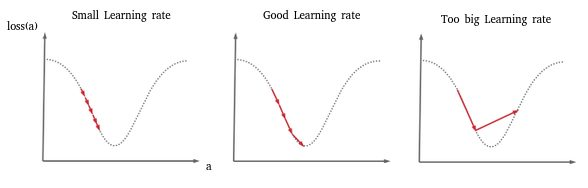

In [15]:
Image("./images/learning_rate.jpg", width=800)

#### Probl√®mes classiques de la descente de gradient

1. #### Minima locaux

Il y'a plusieurs minima locaux (des creux)

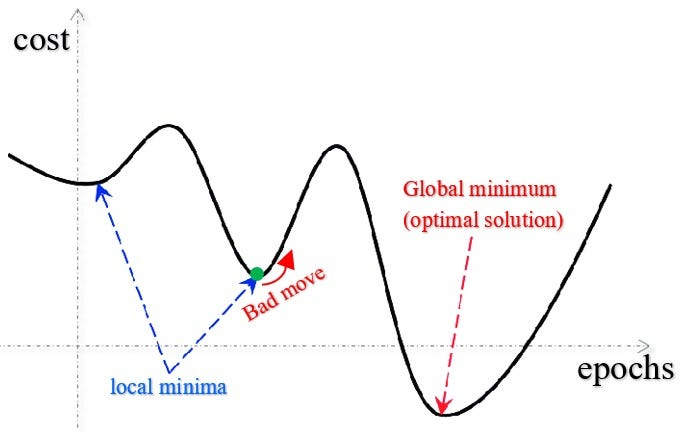

: 

In [ ]:
Image("./images/minima.jpg", width=700)


Ainsi le point de convergence va beaucoup d√©pendre du point initial (initi√© al√©atoirement).

Parfois l'algo trouve bien le minimum global, d'autres fois il convergence sur un minimum local.

**Solution ? faire tourner l'algo plusieurs fois et garder le plus petit des minima.**

2. #### Disparition de gradient

Lorsque le gradient est trop petit.

Le gradient diminue au fil de la r√©tropropagation, faisant que les couches ant√©rieures du r√©seau de neurones apprennent plus lentement que les autres.

**Solution ? utiliser une fonction d'activation lors de l'apprentissage (comme ReLU)**

3. #### Explosion de gradient

Quand le gradient est trop grand => cr√©e un mod√®le instable.

**Solution ? r√©duire la dimensionnalit√© des donn√©es peut aider dans ce cas**

## Etape 3 : Evaluation du mod√®le

### Utilisation de l'ensemble de test

On √©value la pr√©cision du mod√®le sur notre ensemble de test. Il n'a pas servi √† l'entrainement, donc le mod√®le ne l'a jamais vu.

In [8]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Pr√©cision sur les donn√©es de test: {test_acc * 100:.2f}%')

1212/1212 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2ms/step - accuracy: 0.9897 - loss: 0.0811
Pr√©cision sur les donn√©es de test: 98.87%


**Comprendre les r√©sultats** : 
- test_loss : La perte (loss), quantifie l'erreur entre les pr√©dictions du mod√®le et les vraies valeurs.
- test_acc : La pr√©cision (accuracy), repr√©sente le pourcentage de pr√©dictions correctes.

### Visualiser l'√©volution de la perte (loss) et de la pr√©cision (accuracy) au cours de l'entrainement

**Quel int√©r√™t ?**

Observer comment le mod√®le progresse et identifier d'√©ventuels probl√®me d'apprentissage.

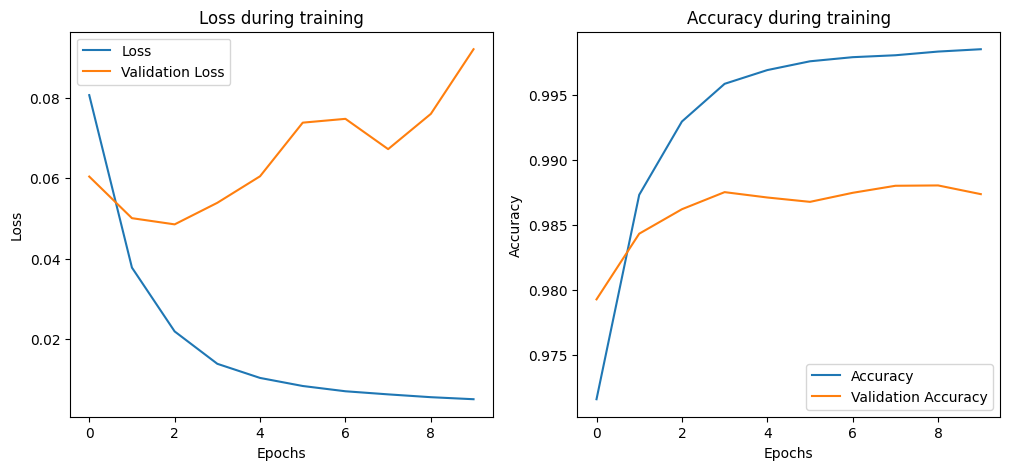

In [15]:
#  Trac√© de la perte et de la pr√©cision
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss during training')
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy during training')
    
    plt.show()

plot_training_history(history)

**Observation :** 
- Les pertes d'entrainement et de validation sont d√©j√† faibles au d√©but. Celle d'entrainement diminue tandis que celle de validation augmente un peu.
- Les pr√©cisions d'entrainement et de validation sont d√©j√† √©lev√©es au d√©but. Celle de validation augmente moins que celle d'entrainement.

**Cela laisse sugg√©rer un l√©ger surapprentissage.**

### Explication : Matrice de confusion et rapport de classification

1. **Matrice de confusion**

Dans le cadre d'une classification binaire (Spam/Ham), une matrice de confusion permet de visualiser les erreurs de classification : 

[[TN  FP]

 [FN  TP]]

- TN : True Negative (emails non-spam classifi√©s correctement)
- FP : False Positive (emails spam classifi√©s comme non-spam)
- FN : False Negative (emails non-spam classifi√©s comme spam)
- TP : True Positive (emails spam classifi√©s correctement)

2. **Rapport de classification**

Permet d'obtenir un rapport d√©taill√© des performance du mod√®le : 
- Pr√©cision (Precision) : Proportion de vrais positifs parmi toutes les pr√©dictions positives.
- Rappel (Recall) : Proportion de vrais positifs d√©tect√©s parmi les r√©els positifs.
- F1-score : Moyenne harmonique entre pr√©cision et rappel.
- Support : Nombre d‚Äô√©chantillons par classe.

In [17]:
# show what texts were been wrongfully classified
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")

print(classification_report(y_test, y_pred))

1212/1212 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 988us/step
Confusion Matrix:
[[20077   240]
 [  249 18204]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     20317
           1       0.99      0.99      0.99     18453

    accuracy                           0.99     38770
   macro avg       0.99      0.99      0.99     38770
weighted avg       0.99      0.99      0.99     38770



### Afficher les emails mal classifi√©s

**Quel int√©r√™t ?**

- Permet d'analyser les erreurs du mod√®le.
- Aide √† comprendre quels types d'emails sont mal classifi√©s.
- Peut √™tre utilis√© pour am√©liorer le mod√®le (ajouter plus de donn√©es, ajuster le seuil, am√©liorer les features, etc.).

In [18]:
#  Identification des emails mal classifi√©s
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
misclassified_indices = np.where(y_pred != y_test)[0]
misclassified_emails = df.iloc[misclassified_indices]
print("Mails mal classifi√©s:")
print(misclassified_emails[['text', 'label']])

1212/1212 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 891us/step
Mails mal classifi√©s:
                                                    text label
55     they are apparently not going to roll over .\n...   Ham
263    lncrease your cum vescapenumberlume and orgasm...  Spam
277    on jun escapenumber escapenumber escapenumber ...   Ham
506    mr edward lugard bills exchange department iri...  Spam
528    get canm . ob first thing monday , this is goi...  Spam
...                                                  ...   ...
38214  if anyone has seen our dog meesha please call ...   Ham
38236  want to be the top all night long be sexual gi...  Spam
38514  in the wake of us and british military action ...   Ham
38606  this is the postfix program at host mx 2 . oi ...  Spam
38721  another option is to use ntldr the windows nt ...   Ham

[489 rows x 2 columns]
